# Import Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from cv2 import cv2
from skimage import feature
from sklearn import neighbors


# Retrieve Dataset

In [13]:
from preprocess import retrieve_dataset, preprocess, to_np

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_filter_negative': True,
  'reduce_dataset_to': 300,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_filter_negative': True,
  'reduce_dataset_to': 75,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

# Extract X_train, Y_train, X_test, Y_test

In [14]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [15]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 300
Length of X_test: 75


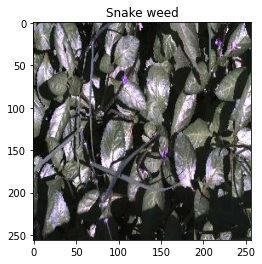

In [16]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [17]:
from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [18]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

# Flatten To Feed into KNN

In [19]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(300,)
feature size now: (256, 256, 3)


In [20]:
# For KNN, K Fold is just to look at prediction across various sets of data
X_full = list(X_train_flatten) + list(X_test_flatten)
y_full = list(y_train) + list(y_test)

print(len(X_full))
print(len(y_full))

375
375


# Test Model with K Fold Validation

In [32]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import kfold_cross_validation

In [33]:
n_neighbors_arr = [5, 10, 15, 20]
k = 5
final_accuracies = []
for n_neighbors in n_neighbors_arr:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'knn', {'n_neighbors': n_neighbors})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for knn with {'n_neighbors': 5}
Split evaluation metrics: {'accuracy': 0.3333333333333333, 'macro_avg': 0.35104166666666664, 'f1_score_macro': 0.3000871269253622, 'micro_avg': 0.3333333333333333, 'f1_score_micro': 0.3333333333333333, 'roc_auc_score': 0.7216444843069196}
Split evaluation metrics: {'accuracy': 0.3333333333333333, 'macro_avg': 0.4705128205128205, 'f1_score_macro': 0.35313852813852814, 'micro_avg': 0.3333333333333333, 'f1_score_micro': 0.3333333333333333, 'roc_auc_score': 0.7635430035772853}
Split evaluation metrics: {'accuracy': 0.3333333333333333, 'macro_avg': 0.41316526610644255, 'f1_score_macro': 0.3340378069997635, 'micro_avg': 0.3333333333333333, 'f1_score_micro': 0.3333333333333333, 'roc_auc_score': 0.775293840000622}
Split evaluation metrics: {'accuracy': 0.38333333333333336, 'macro_avg': 0.43773101898101896, 'f1_score_macro': 0.37167115327912537, 'micro_avg': 0.38333333333333336, 'f1_score_micro': 0.38333333333333336, 'roc_auc_score

In [34]:
print(final_accuracies)

[0.37666666666666665, 0.37, 0.33666666666666667, 0.32999999999999996]
